In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [21]:
# Charger le fichier CSV dans un DataFrame pandas
df = pd.read_csv('nettoyage1.csv', delimiter=";")

# Convertir la colonne "Date/Heure2" en objet DateTime
df['Date/Heure2'] = pd.to_datetime(df['Date/Heure2'])

# Extraire la date (sans l'heure) pour chaque ligne
df['Date'] = df['Date/Heure2'].dt.date

# Supprimer la colonne "Date/Heure2"
df = df.drop(columns=['Date/Heure2'])

# Regrouper les données par jour et calculer la moyenne de chaque colonne pour chaque jour
df = df.groupby('Date').mean().reset_index()

# Enregistrer les données dans un nouveau fichier CSV
df.to_csv('resultat.csv', index=False)

# Afficher le DataFrame résultant
print(df)

            Date         NO        NO2        PM10       PM2.5         CO2  \
0     2013-01-01  47.504601  49.767253  311.782609  117.608696  425.217391   
1     2013-01-02  47.504601  49.767253  373.808166  136.333333  533.190624   
2     2013-01-03  47.504601  49.767253  364.166667  144.250000  524.664375   
3     2013-01-04  60.294734  46.886502  362.849833  145.699185  566.646666   
4     2013-01-05  60.541667  35.708333  315.333333  125.699185  518.875000   
...          ...        ...        ...         ...         ...         ...   
4070  2024-04-03  43.939609  40.958333  108.083333   41.416667  520.500000   
4071  2024-04-04  36.544734  31.500000  115.166667   40.625000  519.500000   
4072  2024-04-05  21.917050  40.083333   87.516499   35.824185  532.041667   
4073  2024-04-06  22.918584  40.291667   75.708333   32.740852  556.291667   
4074  2024-04-07  40.128834  27.875000   82.016499   34.240852  522.416667   

           TEMP       HUMI  
0     20.000000  48.130435  
1    

In [22]:
#calcule de qualiter de l'aire

In [23]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

df["PM2.5_SubIndex"] = df["PM2.5"].apply(lambda x: get_PM25_subindex(x))

## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

df["PM10_SubIndex"] = df["PM10"].apply(lambda x: get_PM10_subindex(x))


## NOx Sub-Index calculation
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

df["NO_SubIndex"] = df["NO"].apply(lambda x: get_NOx_subindex(x))
df["NO2_SubIndex"] = df["NO2"].apply(lambda x: get_NOx_subindex(x))


In [24]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

df["Checks"] = (df["PM2.5_SubIndex"] > 0).astype(int) + \
                (df["PM10_SubIndex"] > 0).astype(int) + \
                (df["NO_SubIndex"] > 0).astype(int) + \
                (df["NO2_SubIndex"] > 0).astype(int) 

df["AQI_calculated"] = round(df[["PM2.5_SubIndex", "PM10_SubIndex", "NO_SubIndex",
                                 "NO2_SubIndex"]].max(axis = 1))
df.loc[df["PM2.5_SubIndex"] + df["PM10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
df.loc[df.Checks < 3, "AQI_calculated"] = np.NaN

df["AQI_bucket_calculated"] = df["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
df[~df.AQI_calculated.isna()].head(13)

,Date,NO,NO2,PM10,PM2.5,CO2,TEMP,HUMI,PM2.5_SubIndex,PM10_SubIndex,NO_SubIndex,NO2_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
0,2013-01-01,47.504601,49.767253,311.782609,117.608696,425.217391,20.000000,48.130435,292.028986,261.782609,59.380751,62.209066,4,292.0,Poor
1,2013-01-02,47.504601,49.767253,373.808166,136.333333,533.190624,19.875000,46.541667,312.564103,329.760208,59.380751,62.209066,4,330.0,Very Poor
2,2013-01-03,47.504601,49.767253,364.166667,144.250000,524.664375,20.375000,51.416667,318.653846,317.708333,59.380751,62.209066,4,319.0,Very Poor
3,2013-01-04,60.294734,46.886502,362.849833,145.699185,566.646666,20.791667,50.416667,319.768604,316.062291,75.368417,58.608128,4,320.0,Very Poor
4,2013-01-05,60.541667,35.708333,315.333333,125.699185,518.875000,20.625000,49.625000,304.383988,265.333333,75.677083,44.635417,4,304.0,Very Poor
5,2013-01-06,59.708333,29.500000,297.208333,119.208333,479.708333,19.875000,48.583333,297.361111,247.208333,74.635417,36.875000,4,297.0,Poor
6,2013-01-07,55.875000,36.083333,255.833333,97.615852,550.208333,19.875000,46.666667,225.386172,205.833333,69.843750,45.104167,4,225.0,Poor
7,2013-01-08,69.354358,40.916667,158.625000,68.750000,546.041667,19.333333,44.708333,129.166667,139.083333,86.692948,51.145833,4,139.0,Moderate
8,2013-01-09,74.333333,31.916667,243.375000,89.449185,580.125000,18.875000,45.458333,198.163950,195.583333,92.916667,39.895833,4,198.0,Moderate
9,2013-01-10,102.875000,35.583333,136.916667,48.875000,579.166667,18.958333,48.416667,81.458333,124.611111,122.875000,44.479167,4,125.0,Moderate


In [25]:
# Diviser les données en ensembles d'entraînement et de test
df.dropna(inplace=True)

X = df.drop(columns=["AQI_bucket_calculated", "Date"])  # Features
y = df["AQI_bucket_calculated"]  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer et entraîner le modèle (Random Forest Classifier par exemple)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


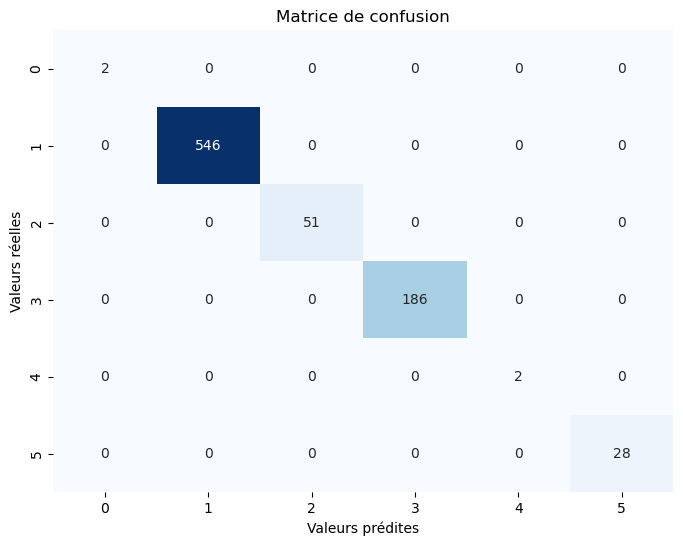

In [26]:
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion')
plt.show()